In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import glob
import os

from scipy import signal
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


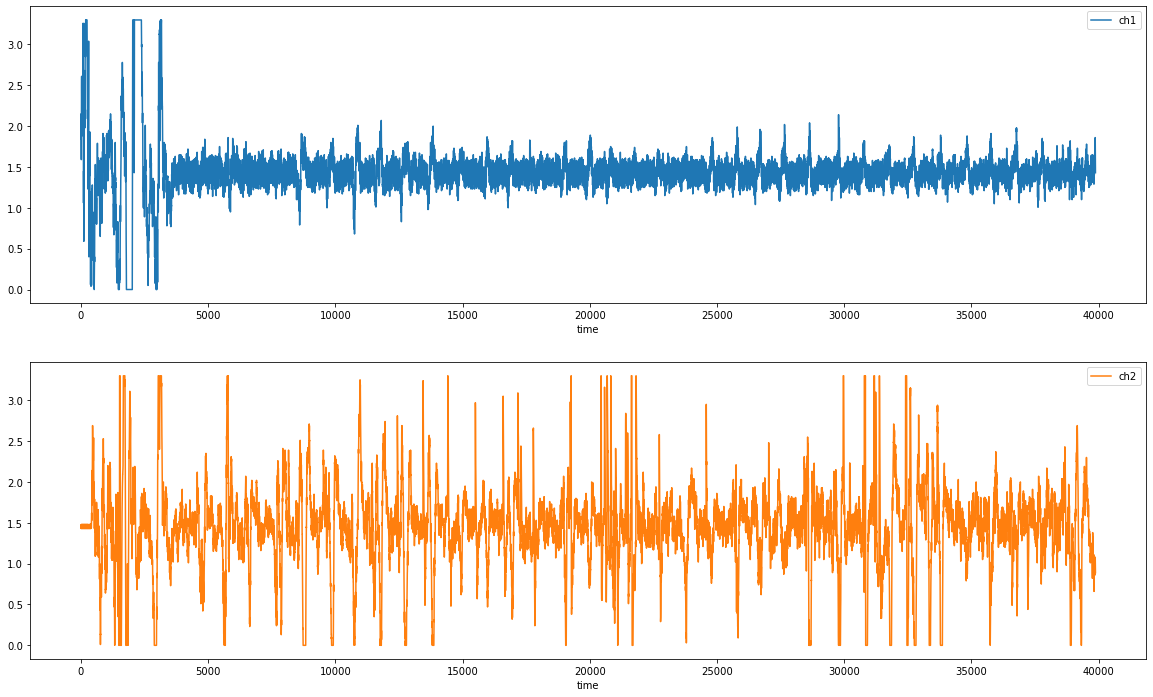

In [5]:
df = pd.read_csv('dataset/20211122/no.csv')

ax = df.plot(x='time', subplots=True, sharex=False, sharey=True, figsize=(20, 12))

Text(0.5, 1.0, 'FFT test')

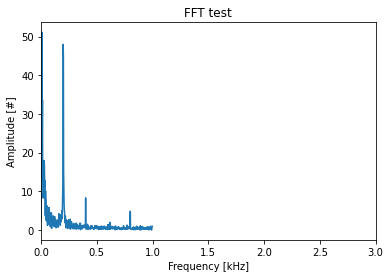

In [6]:
# FFT
rate = 2000

N = 2**10
data = df['ch1'].values[2*rate: 2*rate + N]
y = data
 
F = np.fft.fft(y)
freq = np.fft.fftfreq(N, d=1/rate)
 
Amp = np.abs(F)
 
plt.plot(freq[1:int(N/2)]/1000 , Amp[1:int(N/2)])
plt.xlim(0,3)
plt.xlabel("Frequency [kHz]")
plt.ylabel("Amplitude [#]")
plt.title("FFT test")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9887d6d90>,
      dtype=object)

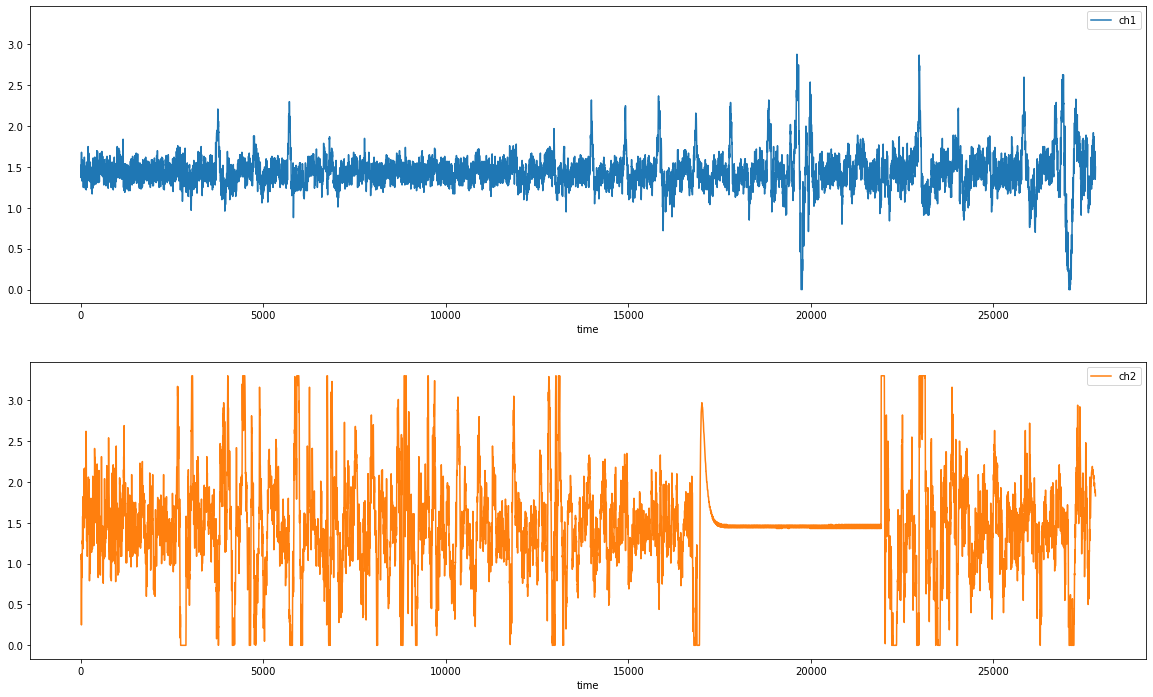

In [7]:
df = pd.read_csv('dataset/20211122/yes.csv')

df.plot(x='time', subplots=True, sharex=False, sharey=True, figsize=(20, 12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb988712b50>,
      dtype=object)

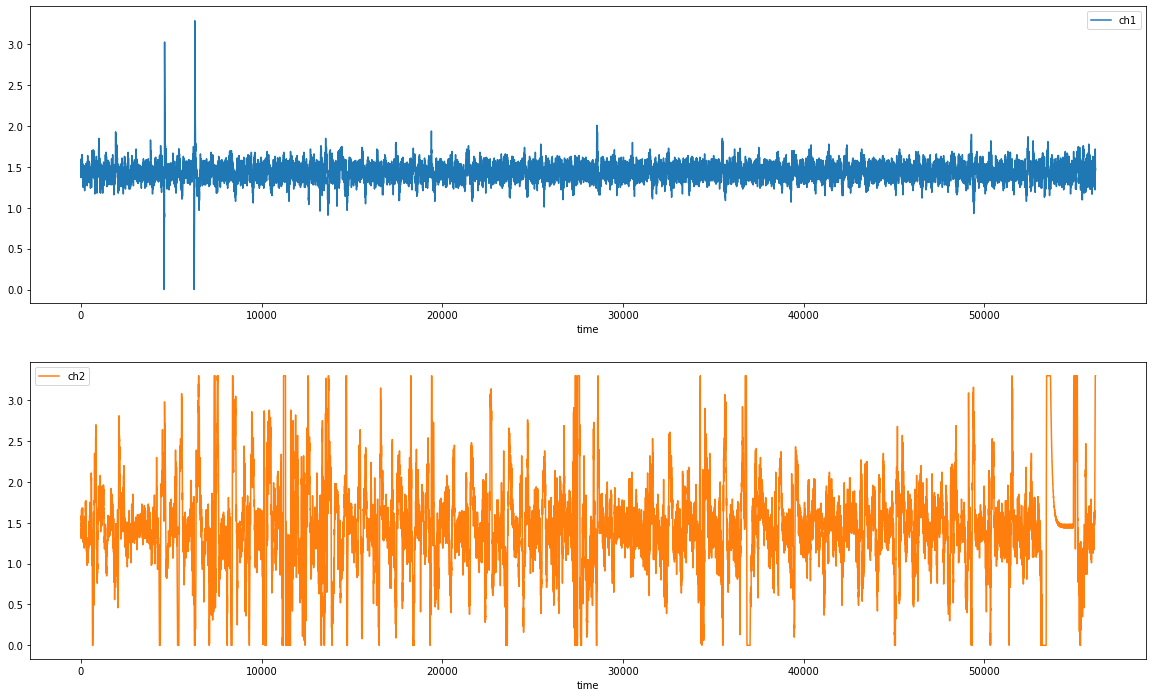

In [8]:
df = pd.read_csv('dataset/20211122/start.csv')

df.plot(x='time', subplots=True, sharex=False, sharey=True, figsize=(20, 12))

In [9]:
df = pd.read_csv('dataset/20211122/no.csv')
df['ch1'][0:1000]
df['ch2'][0:1000]


foo = np.array([df['ch1'][0:1000].T.values, df['ch2'][0:1000].T.values])
print(foo)

[[1.84 2.02 2.1  ... 0.   0.   0.  ]
 [1.47 1.46 1.44 ... 1.56 1.62 1.52]]


In [10]:
pip install python_speech_features

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 参考サイト
https://qiita.com/everylittle/items/24aeb19fc586ded8e218
https://github.com/igormq/ctc_tensorflow_example
utilsが他のライブラリと衝突するぽいので、utils2みたいに名前を変える

In [81]:
#  Compatibility imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import tensorflow as tf
import scipy.io.wavfile as wav
import numpy as np

from six.moves import xrange as range

try:
    from python_speech_features import mfcc
except ImportError:
    print("Failed to import python_speech_features.\n Try pip install python_speech_features.")
    raise ImportError

from utils2 import maybe_download as maybe_download
from utils2 import sparse_tuple_from as sparse_tuple_from

# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space
FEAT_MASK_VALUE = 1e+10

# Some configs
num_features = 13
num_units = 50 # Number of units in the LSTM cell
# Accounting the 0th indice +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

# Hyper-parameters
num_epochs = 400
num_layers = 1
batch_size = 2
initial_learning_rate = 0.005
momentum = 0.9

# Loading the data

#audio_filename = maybe_download('LDC93S1.wav', 93638)
#target_filename = maybe_download('LDC93S1.txt', 62)

#fs, audio = wav.read(audio_filename)

fs = 1000
audio = df['ch2'][6000:10000].values
target_filename = 'start.txt'

# create a dataset composed of data with variable lengths
inputs = mfcc(audio, samplerate=fs)
inputs = (inputs - np.mean(inputs))/np.std(inputs)
inputs_short = mfcc(audio[fs*8//10:fs*20//10], samplerate=fs)
inputs_short = (inputs_short - np.mean(inputs_short))/np.std(inputs_short)
# Transform in 3D array
train_inputs = tf.ragged.constant([inputs, inputs_short], dtype=np.float32)
train_seq_len = tf.cast(train_inputs.row_lengths(), tf.int32)
train_inputs = train_inputs.to_tensor(default_value=FEAT_MASK_VALUE)

# Reading targets
with open(target_filename, 'r') as f:

    #Only the last line is necessary
    line = f.readlines()[-1]

    # Get only the words between [a-z] and replace period for none
    original = ' '.join(line.strip().lower().split(' ')[2:]).replace('.', '')
    targets = original.replace(' ', '  ')
    targets = targets.split(' ')
    
    print(targets)

# Adding blank label
targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

print(targets)

# Transform char into index
targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                      for x in targets])

print(targets)

# Creating sparse representation to feed the placeholder
train_targets = tf.ragged.constant([targets, targets[13:32]], dtype=np.int32)

print(train_targets)

train_targets_len = tf.cast(train_targets.row_lengths(), tf.int32)

train_targets = train_targets.to_sparse() 

print(train_targets)

# We don't have a validation dataset :(
val_inputs, val_targets, val_seq_len, val_targets_len = train_inputs, train_targets, \
                                                        train_seq_len, train_targets_len

# THE MAIN CODE!

# add loss and metrics with a custom layer
class CTCLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        labels = inputs[0]
        logits = inputs[1]
        label_len = inputs[2]
        logit_len = inputs[3]

        logits_trans = tf.transpose(logits, (1, 0, 2))
        label_len = tf.reshape(label_len, (-1,))
        logit_len = tf.reshape(logit_len, (-1,))
        loss = tf.reduce_mean(tf.nn.ctc_loss(labels, logits_trans, label_len, logit_len, blank_index=-1))
        # define loss here instead of compile()
        self.add_loss(loss)

        # decode
        decoded, _ = tf.nn.ctc_greedy_decoder(logits_trans, logit_len)

        # Inaccuracy: label error rate
        ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          labels))
        self.add_metric(ler, name="ler", aggregation="mean")

        return logits  # Pass-through layer.

# Defining the cell
# Can be:
#   tf.nn.rnn_cell.RNNCell
#   tf.nn.rnn_cell.GRUCell 
cells = []
for _ in range(num_layers):
    cell = tf.keras.layers.LSTMCell(num_units)  # Or LSTMCell(num_units)
    cells.append(cell)
stack = tf.keras.layers.StackedRNNCells(cells)

input_feature     = tf.keras.layers.Input((None, num_features), name="input_feature")
input_label       = tf.keras.layers.Input((None,), dtype=tf.int32, sparse=True, name="input_label")
input_feature_len = tf.keras.layers.Input((1,), dtype=tf.int32, name="input_feature_len")
input_label_len   = tf.keras.layers.Input((1,), dtype=tf.int32, name="input_label_len")

layer_masking = tf.keras.layers.Masking(FEAT_MASK_VALUE)(input_feature)
layer_rnn     = tf.keras.layers.RNN(stack, return_sequences=True)(layer_masking)
layer_output  = tf.keras.layers.Dense(
                   num_classes,
                   kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.1),
                   bias_initializer="zeros",
                   name="logit")(layer_rnn)
layer_loss = CTCLossLayer()([input_label, layer_output, input_label_len, input_feature_len])

# create models for training and prediction (sharing weights)
model_train = tf.keras.models.Model(
            inputs=[input_feature, input_label, input_feature_len, input_label_len],
            outputs=layer_loss)

model_predict = tf.keras.models.Model(inputs=input_feature, outputs=layer_output)

optimizer = tf.keras.optimizers.SGD(initial_learning_rate, momentum)
# adding no loss: we have already defined with a custom layer
model_train.compile(optimizer=optimizer)

# training: y is dummy!
history = model_train.fit(x=[train_inputs, train_targets, train_seq_len, train_targets_len], y=None,
                validation_data=([val_inputs, val_targets, val_seq_len, val_targets_len], None),
                epochs=num_epochs)

# Decoding
print('Original:')
print(original)
# print(original[13:32])
print('Decoded:')
decoded, _ = tf.nn.ctc_greedy_decoder(tf.transpose(model_predict.predict(train_inputs), (1, 0, 2)), train_seq_len)
d = tf.sparse.to_dense(decoded[0], default_value=-1).numpy()
str_decoded = [''.join([chr(x + FIRST_INDEX) for x in np.asarray(row) if x != -1]) for row in d]
for s in str_decoded:
    # Replacing blank label to none
    s = s.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    s = s.replace(chr(ord('a') - 1), ' ')
    print(s)

['start', '', 'start', '', 'start', '', 'start']
['s' 't' 'a' 'r' 't' '<space>' 's' 't' 'a' 'r' 't' '<space>' 's' 't' 'a'
 'r' 't' '<space>' 's' 't' 'a' 'r' 't']
[19 20  1 18 20  0 19 20  1 18 20  0 19 20  1 18 20  0 19 20  1 18 20]
<tf.RaggedTensor [[19, 20, 1, 18, 20, 0, 19, 20, 1, 18, 20, 0, 19, 20, 1, 18, 20, 0, 19, 20, 1, 18, 20], [20, 1, 18, 20, 0, 19, 20, 1, 18, 20]]>
SparseTensor(indices=tf.Tensor(
[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]], shape=(33, 2), dtype=int64), values=tf.Tensor(
[19 20  1 18 20  0 19 20  1 18 20  0 19 20  1 18 20  0 19 20  1 18 20 20
  1 18 20  0 19 20  1 18 20], shape=(33,), dtype=int32), dense_shape=tf.Tensor([ 2 23], shape=(2,), dtype=int64))
Epoch 1/400
1/1 [==============================] - 2s 2s/

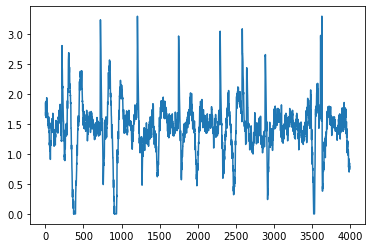

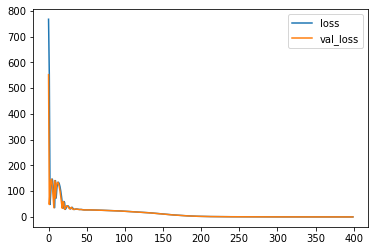

In [87]:
plt.plot(df['ch2'][6000:10000].values)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [52]:
#model_train.predict([train_inputs, train_targets, train_seq_len, train_targets_len])

array([[[ 2.2459254, -1.1985024, -1.2271719, ...,  3.6821709,
         -1.3737257, 13.582634 ],
        [ 3.8779504, -1.5464756, -1.6287377, ...,  4.766634 ,
         -1.829408 , 20.07817  ],
        [ 3.194189 , -1.0934646, -1.2459033, ...,  5.427265 ,
         -1.4385288, 16.367085 ],
        ...,
        [ 5.150827 , -1.3612741, -1.6632433, ...,  5.804202 ,
         -1.9450579, 11.813986 ],
        [ 6.5294294, -1.4173547, -1.782255 , ...,  2.915097 ,
         -1.7007041,  5.1076927],
        [ 4.1603003, -1.5053084, -1.4754235, ...,  0.5135515,
         -1.4132731, 13.008068 ]],

       [[ 3.2947614, -1.3635417, -1.3740356, ...,  3.3932798,
         -1.4879515, 16.315887 ],
        [ 2.3509202, -1.088492 , -1.1625869, ...,  3.290893 ,
         -1.3274114, 13.874474 ],
        [ 6.7847958, -1.7870588, -1.9459146, ...,  4.2004704,
         -2.171739 , 16.172993 ],
        ...,
        [ 4.2807264, -1.6845033, -1.7115259, ...,  3.0540302,
         -1.8875737, 22.26456  ],
        [ 4.

In [93]:
fs = 1000
audio = df['ch2'][16000:20000].values
target_filename = 'start.txt'

# create a dataset composed of data with variable lengths
inputs = mfcc(audio, samplerate=fs)
inputs = (inputs - np.mean(inputs))/np.std(inputs)
inputs_short = mfcc(audio[fs*8//10:fs*20//10], samplerate=fs)
inputs_short = (inputs_short - np.mean(inputs_short))/np.std(inputs_short)
# Transform in 3D array
train_inputs = tf.ragged.constant([inputs, inputs_short], dtype=np.float32)
train_seq_len = tf.cast(train_inputs.row_lengths(), tf.int32)
train_inputs = train_inputs.to_tensor(default_value=FEAT_MASK_VALUE)

# Decoding
print('Original:')
print(original)
#print(original[13:32])
print('Decoded:')
decoded, _ = tf.nn.ctc_greedy_decoder(tf.transpose(model_predict.predict(train_inputs), (1, 0, 2)), train_seq_len)
d = tf.sparse.to_dense(decoded[0], default_value=-1).numpy()
str_decoded = [''.join([chr(x + FIRST_INDEX) for x in np.asarray(row) if x != -1]) for row in d]
for s in str_decoded:
    # Replacing blank label to none
    s = s.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    s = s.replace(chr(ord('a') - 1), ' ')
    print(s)

Original:
start start start start
Decoded:
st  tst s   
st
